# Калибровка вероятностей

Пуфффф


И вот я снова пишу в тетрадку заметки, есть [страница в официальной документации Scikit Learn](https://scikit-learn.org/1.5/modules/calibration.html) где говориться о калибровке вероятностей.

У классов `sklearn` есть методы, похожие по сигнатуре и названию на `.predict_proba(X)` - которые у моделей классификации возвращают вероятность, что объект относиться к предсказнному классу, всё прекрасно, но если было бы так, то не пришлось бы писать в тетрадку

Метод `.predict_proba()` возвращает "оценку уверенности" модели в предсказании, т.е. это другое число, которое может не совпадать с настоящей вероятностью предсказания, допустим, модель скажет "Клиент вернёт кредит, уверена на 0.9", а настоящая вероятность 0.6 ;некрасиво, так-то;

Есть небольшое исключение в виде Логистической регрессии, которая умеет предсказывать именно вероятности, т.к. под капотом лежит максимизация правдоподобия, основанного на вероятностях


In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()

DATA_FOLDER = pathlib.Path(".").resolve().parent / "data"

In [ ]:
df = pd.read_csv(DATA_FOLDER / "loan_data.csv")

X = df.drop("loan_status", axis=1)

numerical_columns = X.columns[X.dtypes != "object"]
X = X[numerical_columns]

y = df["loan_status"]
X.sample(20)

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score
31581,41.0,133045.0,17,20000.0,13.35,0.15,17.0,710
17453,23.0,80216.0,0,9200.0,11.86,0.11,2.0,674
29318,38.0,81086.0,14,20000.0,14.59,0.25,14.0,707
42553,23.0,130687.0,1,10000.0,11.07,0.08,3.0,621
3513,22.0,44376.0,0,10500.0,10.74,0.24,2.0,623
13887,25.0,118055.0,5,8000.0,7.49,0.07,2.0,650
19752,27.0,43036.0,5,3500.0,8.59,0.08,6.0,617
7506,25.0,85098.0,3,6800.0,5.42,0.08,2.0,618
6397,22.0,46684.0,2,6000.0,13.57,0.13,4.0,577
23946,27.0,82921.0,4,30000.0,15.99,0.36,7.0,639


In [ ]:
y.value_counts()

loan_status
0    35000
1    10000
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [ ]:
def get_plot_data(y_true, y_proba, quantiles=[0.25, 0.5, 0.75]) -> pd.DataFrame:
    d = pd.DataFrame()
    d["y_proba"] = y_proba
    d["y_true"] = y_test.to_numpy()
    bins = np.quantile(d["y_proba"], quantiles)
    d["bin"] = np.searchsorted(bins, d["y_proba"])
    d = (
        d.groupby("bin")
        .agg(
            total=("bin", "count"), y_true=("y_true", "sum"), y_proba=("y_proba", "sum")
        )
        .reset_index()
    )
    d["y_true"] = d["y_true"] / d["total"]
    d["y_proba"] = d["y_proba"] / d["total"]
    return d

/Users/dimnktn/Desktop/development/ds_self_practice/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/rc/dz40hxw14yg8cgj4yn4n05700000gn/T/ipykernel_92802/1613893823.py:18: MatplotlibDeprecationWarning: Passing label as a length 100 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.plot(d["y_proba"], d["y_true"], marker=marker, label=m)


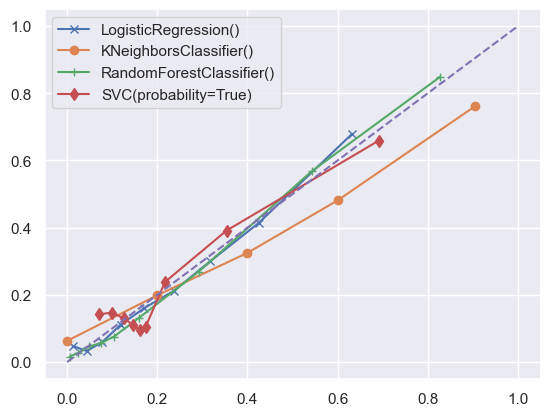

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

_, ax = plt.subplots()

quantiles = np.linspace(0, 1, 10)

models = [
    LogisticRegression(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    SVC(probability=True),
]
markers = ["x", "o", "+", "d"]
for m, marker in zip(models, markers):
    m.fit(X_train, y_train)
    y_proba = m.predict_proba(X_test)[:, 1]

    d = get_plot_data(y_test, y_proba, quantiles[1:-1])
    ax.plot(d["y_proba"], d["y_true"], marker=marker, label=m)

ax.plot(quantiles, quantiles, linestyle="dashed")
plt.legend()
plt.show()

## Калибровка Платта (Sigmoid)


А давайте обучим модель, предскажем увернность модели, а на предсказнностях обучим логистическую регрессию и уже на тестовой части данных предскажем вероятности близкие к истинным


In [22]:
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.4, random_state=42
)

/Users/dimnktn/Desktop/development/ds_self_practice/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


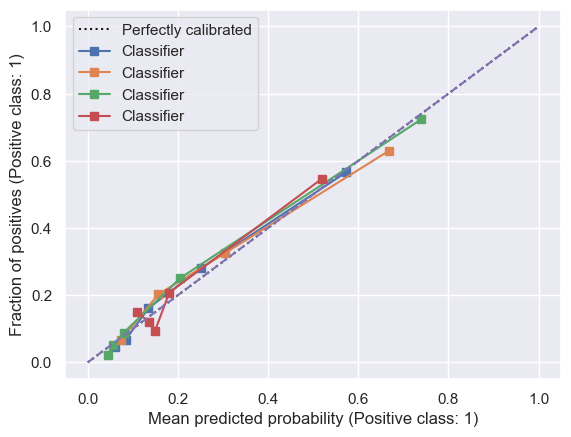

In [ ]:
_, ax = plt.subplots()


for m, marker in zip(models, markers):
    m.fit(X_train_new, y_train_new)

    y_proba_fit = m.predict_proba(X_val)[:, 1]
    y_proba_fit = y_proba_fit.reshape(-1, 1)

    lr = LogisticRegression()
    lr.fit(y_proba_fit, y_val)

    y_proba_predict = m.predict_proba(X_test)[:, 1]
    y_proba_predict = y_proba_predict.reshape(-1, 1)

    y_proba = lr.predict_proba(y_proba_predict)[:, 1]

    d = get_plot_data(y_test, y_proba, quantiles[1:-1])
    ax.plot(d["y_proba"], d["y_true"], label=m, marker=marker)

ax.plot(quantiles, quantiles, linestyle="dashed")
plt.legend()
plt.show()

На графиках выше можно увидеть разницу, что оценка вероятности на KNN стала ближе к истинной, однако требуется выделять часть данных на обучение логистической регрессии, что может отразиться на качестве самой модели

Чтобы дальше не заниматься самописательством, используем готовые функции sklearn